In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import datetime
import time
import pickle
import json

from pymongo import MongoClient
from pprint import pprint
from gensim.models import CoherenceModel
from nltk.tag import StanfordNERTagger 
from nltk.corpus import stopwords

from themeter.dev.model_testing import get_coherence_vals
from text_processing import (tag_words,remove_stopwords,
                             remove_sw,process_doc,
                            bigrams,refactor_corpus,get_corpus)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [334]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Database Retrieval

Having stored my database on Mongo previously, all I need to do is connect to my database and retrieve the data. When the data is retrieved from Mongo, it comes with an extra id column. Since the id is of no use to me I will drop it and check my dataframe.

In [269]:
# with open('/Users/alexanderbailey/.secret/mongo_creds.json','r') as f:
#     params = json.load(f)

# url = 'mongodb+srv://zmbailey:' + params['password'] + '@cluster0-ykzgc.mongodb.net/test?retryWrites=true&w=majority'

# client = MongoClient(url)

In [271]:
# mongodb = client.movieplots
# mongo_summaries = mongodb.movies
# movies = pd.DataFrame(list(mongo_summaries.find()))
# movies = movies[['summary','title']]
# print(movies.shape)
# movies.head()

(56005, 2)


,summary,title
0,nown as 1 Life On The Limit is a 2013 document...,1 (2013 film)
1,While on the phone with his girlfriend Jill w...,+1 (film)
2,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film)
3,o Christmas is a Ghanaian drama movie about Re...,6 Hours To Christmas
4,r is a 1995 American romantic drama television...,The Affair (1995 film)


Since you will not have access to my MongoDB, I have also included my data files as json. Here is the code to import those instead:

In [ ]:
movies1_df = pd.read_json('themeter/dev/data/eng_1_430.json')
movies2_df = pd.read_json('themeter/dev/data/eng_431_601.json')
movies = movies1_df.append(movies2_df)
print(movies1_df.shape)
print(movies2_df.shape)
movies.head()

## Data Prepration

My dataset is a little large to work with, given the size of each text entry. Certain operations take an impractical amount of time, so I will take a smaller sample, and break that up for processing.

In [489]:
import random
np.random.seed(1960)
sample = np.random.choice(list(movies['summary']),25000)
sample1 = sample[:12501]
sample2 = sample[12501:]

### Named Entity Recognition

Movie summaries contain a considerable number of names, both of people and places, which throw off the topic modeling. In order to avoid this, I can use NER to identify names so I can remove them. However, NER takes a long time to run on my data, so I have commented the line out, and pickled the results so that I can quickly load it later.   

In [ ]:
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       '/stanford-ner-2018-10-16/stanford-ner.jar')
#names1 = tag_words(sample1, st)
#names2 = tag_words(sample2, st)

In [ ]:
# with open('data/names_list1.pkl', 'wb') as f:
#     pickle.dump(names, f)

In [101]:
with open('data/names_list1.pkl', 'rb') as f1:
    names1 = pickle.load(f1)
with open('data/names_list2.pkl', 'rb') as f2:
    names2 = pickle.load(f2)
    
names = set(names1).union(set(names2))

In [132]:
len(names.union(set(map(lambda x: x.lower(),names))))

113746

Now that I have the list of names I can append it to the stoplist so any names will be removed from the text.

In [131]:
names = names.union(set(map(lambda x: x.lower(),names)))
stop_words = stopwords.words('english')
stop_words += ['film', 'directed', 'film_directed', 'series',
               'story', 'american', 'starring', 'films', 'direct',
               'produced', 'stars', 'released','premiered','features',
              'featuring','interviews','release','version','performances',
              'performance','perform','titled','title','distributed','featured',
              'adaptation','character','role','including']
 
stop_words = set(stop_words).union(names)

In [327]:
# with open('data/stopwords.pkl', 'wb') as f:
#     pickle.dump(stop_words, f)

Now that we have the stopwords configured, we can preprocess the text.

In [133]:
now = datetime.datetime.now()
m_corpus, m_id2word, bigram = get_corpus(sample,stop_words)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

Time:  0:00:19.972509


In [324]:
with open('jar/id2word.pkl','wb') as f:
    pickle.dump(m_id2word,f)

Now I create my first test LDA model, to see what the topics are like. 

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=10,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(num_topics=-1):
    print('Topic : {} Word: {}'.format(idx, topic))

Now I'm creating a series of models to looks at coherence values for different numbers of topics. Coherence values are indicitive of the human interpretability of the topics, so this will help me find topics that will be more meaning output. 

In [453]:
#85 = 8
#125 = 12

# def get_coherence_vals(start,end,step):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start,end,step):
#         model = gensim.models.LdaMulticore(corpus=m_corpus,
#                                            num_topics=num_topics,
#                                            id2word=m_id2word,
#                                            chunksize=100,
#                                            eval_every=1,
#                                            per_word_topics=True,
#                                            passes=20,
#                                            workers=3,
#                                            random_state=125)
#         model_list.append(model)

#         coherencemodel = CoherenceModel(model=model, 
#                                         texts=bigram,
#                                         dictionary=m_id2word,
#                                        coherence='c_v')
#         print('model with ' + str(num_topics) + ' topics')
#         coherence_values.append(coherencemodel.get_coherence())
    
#     return model_list,coherence_values

## First Model

Doing a broad search to look for trends.

In [445]:
now = datetime.datetime.now()
models1, coherence1 = get_coherence_vals(5,20,1,m_corpus,m_id2word,bigram,85)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

model with 120 topics
model with 121 topics
model with 122 topics
model with 123 topics
model with 124 topics
model with 125 topics
model with 126 topics
model with 127 topics
model with 128 topics
model with 129 topics
model with 130 topics
model with 131 topics
model with 132 topics
model with 133 topics
model with 134 topics
model with 135 topics
model with 136 topics
model with 137 topics
model with 138 topics
model with 139 topics
model with 140 topics
model with 141 topics
model with 142 topics
model with 143 topics
model with 144 topics
model with 145 topics
Time:  0:45:36.131585


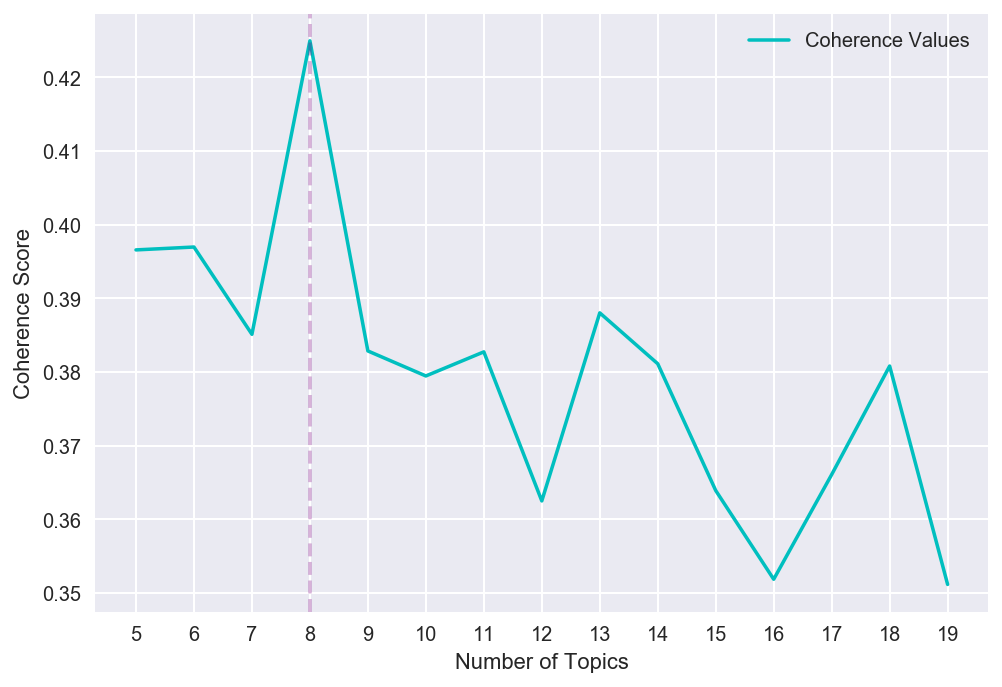

In [495]:

X = range(5,20,1)

fig, ax = plt.subplots()
ax.plot(X, coherence1, color="c", label="Coherence Values")
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_xticks(range(5,20))
ax.axvline(8,linestyle='--',alpha=0.3,color="purple")

plt.legend()

In [545]:
for m, cv in zip(X, coherence4):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 12  has Coherence Value of 0.3654
Num Topics = 13  has Coherence Value of 0.3439
Num Topics = 14  has Coherence Value of 0.3613
Num Topics = 15  has Coherence Value of 0.3673
Num Topics = 16  has Coherence Value of 0.3819
Num Topics = 17  has Coherence Value of 0.3708


From this set of models, it looks like the one wiht 8 topics has the most interpretability.
I will use the 8 topic model from this set.

In [478]:
for topic in range(8):
    print('[', end="")#'Topic ' + str(topic) + ': ')
    for word in range(10):
        print("'" + models1[3].show_topic(topic)[word][0] + "', ", end="")
    print(']')


['ship', 'plane', 'pilot', 'flight', 'bomb', 'passengers', 'ships', 'precode', 'engine', 'launch', ]
['trial', 'evidence', 'murdered', 'tape', 'committed', 'patient', 'guilty', 'patients', 'innocent', 'victim', ]
['th', 'played', 'shown', 'includes', 'final', 'received', 'september', 'focuses', 'called', 'romantic', ]
['tries', 'begins', 'leave', 'runs', 'turns', 'starts', 'attempts', 'apartment', 'gives', 'makes', ]
['debut', 'painting', 'wrote', 'unexpected', 'published', 'millionaire', 'narrator', 'reputation', 'ever', 'inmates', ]
['decides', 'agrees', 'would', 'gives', 'leave', 'makes', 'meets', 'offers', 'reveals', 'plans', ]
['killed', 'named', 'attempt', 'reveals', 'discover', 'attacked', 'attempts', 'led', 'captured', 'others', ]
['relationship', 'begins', 'become', 'meets', 'married', 'career', 'couple', 'yearold', 'pregnant', 'boyfriend', ]


After looking over the 8 topics to confirm coherence, I will now assign names to each topic.

### Topics 1

Action: ['ship', 'plane', 'pilot', 'flight', 'bomb', 'passengers', 'ships', 'precode', 'engine', 'launch', ]

Crime: ['trial', 'evidence', 'murdered', 'tape', 'committed', 'patient', 'guilty', 'patients', 'innocent', 'victim',]

Performance: ['th', 'played', 'shown', 'includes', 'final', 'received', 'september', 'focuses', 'called', 'romantic', ]

On the Run: ['tries', 'begins', 'leave', 'runs', 'turns', 'starts', 'attempts', 'apartment', 'gives', 'makes', ]

Drama: ['debut', 'painting', 'wrote', 'unexpected', 'published', 'millionaire', 'narrator', 'reputation', 'ever', 'inmates', ]

Espionage: ['decides', 'agrees', 'would', 'gives', 'leave', 'makes', 'meets', 'offers', 'reveals', 'plans', ]

Mystery: ['killed', 'named', 'attempt', 'reveals', 'discover', 'attacked', 'attempts', 'led', 'captured', 'others', ]

Romance: ['relationship', 'begins', 'become', 'meets', 'married', 'career', 'couple', 'yearold', 'pregnant', 'boyfriend', ]

## Second Model

Because of the variation in the way topics are generated, I am looking at a second model, to test the possibilty of getting different topics from another seed.

In [ ]:
now = datetime.datetime.now()
models3, coherence3 = get_coherence_vals(5,16,1,m_corpus,m_id2word,bigram,900)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

model with 5 topics
model with 6 topics


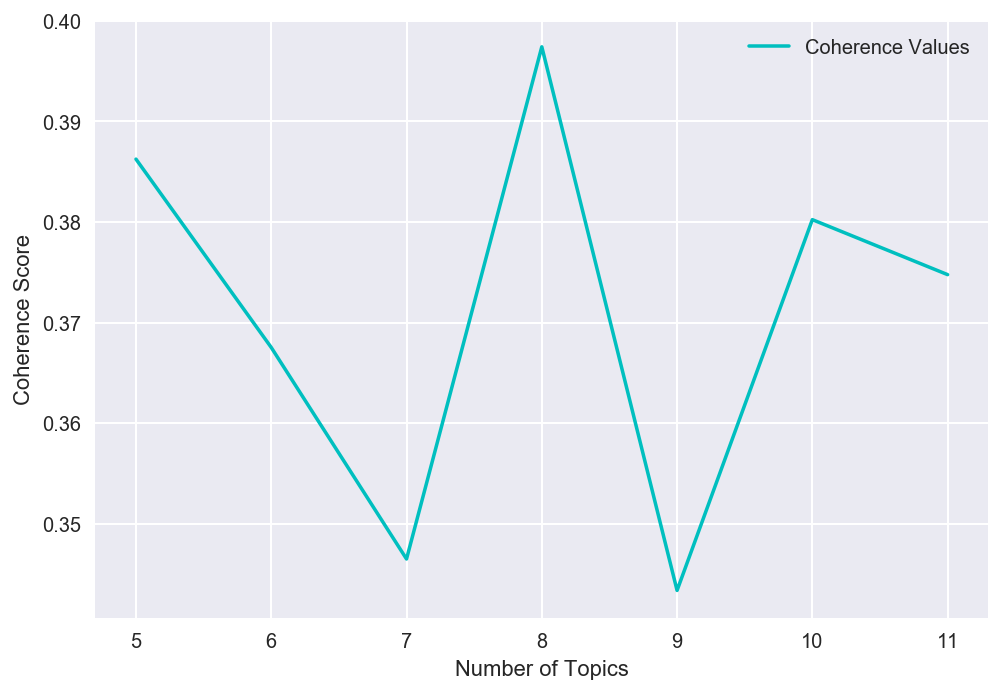

In [547]:

X = range(5,12,1)

fig, ax = plt.subplots()
ax.plot(X, coherence3, color="c", label="Coherence Values")
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_xticks(range(5,12))
#ax.axvline(8,linestyle='--',alpha=0.3,color="purple")

plt.legend()

It now appears that 12 is a good number of topics, so I will investigate the model with 12.

In [548]:
for topic in range(8):
    print('[', end="")#'Topic ' + str(topic) + ': ')
    for word in range(10):
        print("'" + models3[3].show_topic(topic)[word][0] + "', ", end="")
    print(']')


['relationship', 'become', 'decides', 'meets', 'begins', 'would', 'married', 'makes', 'agrees', 'named', ]
['patient', 'december', 'patients', 'experiences', 'wrote', 'documents', 'heroin', 'explores', 'sexual', 'writer', ]
['trial', 'romantic', 'lawyer', 'evidence', 'secretary', 'meeting', 'involved', 'minister', 'sentenced', 'sent', ]
['played', 'th', 'shown', 'includes', 'debut', 'concerns', 'received', 'final', 'focuses', 'called', ]
['plane', 'bomb', 'flight', 'pilot', 'painting', 'passengers', 'helicopter', 'causing', 'onto', 'infected', ]
['tries', 'leave', 'runs', 'apartment', 'begins', 'gives', 'makes', 'starts', 'turns', 'decides', ]
['ship', 'causing', 'tries', 'aliens', 'ships', 'uses', 'humans', 'scientist', 'creatures', 'thriller', ]
['killed', 'named', 'reveals', 'attempts', 'discovers', 'discover', 'attempt', 'others', 'manages', 'taken', ]


These topics look good, so I will assign these topics names.

### Topics 2

Fighting: ['aliens', 'include', 'final', 'powerful', 'screened', 'terrorists', 'teams', 'involves', 'championship', 'theaters', ]

Romance: ['relationship', 'meets', 'leave', 'begins', 'apartment', 'married', 'reveals', 'decides', 'discovers', 'visits', ]

Drama: ['th', 'shown', 'played', 'includes', 'debut', 'concerns', 'received', 'september', 'romantic', 'december', ]

On the Run: ['tries', 'starts', 'runs', 'decides', 'makes', 'getting', 'gives', 'doesnt', 'leave', 'turns', ]

Psychological: ['begins', 'experiences', 'patient', 'shown', 'patients', 'different', 'psychiatrist', 'focuses', 'visions', 'tape', ]

Heist: ['pay', 'hired', 'ticket', 'scheme', 'offers', 'bring', 'gambling', 'sell', 'player', 'plans', ]

Thriller: ['killed', 'reveals', 'plane', 'flight', 'contact', 'sent', 'pilot', 'taken', 'could', 'evidence', ]

Crime Drama: ['killed', 'named', 'plan', 'arrest', 'led', 'criminals', 'thugs', 'sent', 'captured', 'plans', ]

Courtroom: ['trial', 'evidence', 'murdered', 'lawyer', 'accused', 'innocent', 'involved', 'guilty', 'cop', 'victim', ]

Tough Decisions: ['would', 'become', 'decides', 'must', 'could', 'agrees', 'contract', 'named', 'wish', 'plans', ]

Mystery: ['killed', 'attempts', 'tries', 'leave', 'begins', 'discovers', 'named', 'runs', 'turns', 'manages', ]

Action: ['ship', 'bomb', 'helicopter', 'captured', 'others', 'attacked', 'scientist', 'remaining', 'humans', 'ships', ]

In [496]:
topic_names1 = ['Action','Crime','Performance','On the Run','Relationship Drama',
                'Espionage','Mystery','Romance']
topic_names2 = ['Fighting','Romance','Drama','On the Run','Psychological',
               'Heist','Thriller','Crime','Courtroom','Tough Decisions',
               'Mystery','Action']


In [476]:
# with open('themeter/dev/jar/model1.pkl', 'wb') as f:
#     pickle.dump(models1[3],f)
    
# with open('themeter/dev/jar/model2.pkl', 'wb') as e:
#     pickle.dump(models2[5],e)

Now to test the model output with a summary from imdb:

In [472]:
unseen = 'Dr. Richard Kimble, unjustly accused of murdering his wife, must find the real killer' 
unseen += 'while being the target of a nationwide manhunt led by a seasoned U.S. Marshal.'

corp = process_doc(unseen,m_id2word,stop_words)

topic = models8[5].get_document_topics(corp, minimum_probability=0.0)
idx, scores = zip(*topic)
print(topic_names[scores.index(sorted(scores)[-2])])
print(topic_names[scores.index(max(scores))])

Courtroom
Action
